In [39]:
import sys
sys.path.append("../tools/")

from tester import dump_classifier_and_data, test_classifier
from feature_format import featureFormat, targetFeatureSplit
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tester
import pickle
%matplotlib inline


def return_grid_result(grids, features, labels):
    ''' General code to fit and print results from GridSearch '''
    grids.fit(features, labels)
    print 'Best score: ', grids.best_score_
    print 'Best parameter no: ', grids.best_params_
    selected_percentile = grids.best_params_['select__percentile']

    return grids, selected_percentile

def fit_and_predict(features_train_selected, labels_train, features_test_selected, clf):
    ''' Fit model and predict test dataset '''
    clf.fit(features_train_selected, labels_train)
    pred = clf.predict(features_test_selected)

    return clf, pred

def select_best_perc(selected_percentile, features_train, labels_train):
    ''' Select features with SelectPercentile '''
    select = SelectPercentile(percentile=selected_percentile)
    select.fit(features_train, labels_train)
    mask = select.get_support()
    # Transform features and labels
    features_train_selected = select.transform(features_train)
    features_test_selected = select.transform(features_test)

    return mask, features_train_selected, features_test_selected



payment_data = ['salary',
                'bonus',
                'long_term_incentive',
                'deferred_income',
                'deferral_payments',
                'loan_advances',
                'other',
                'expenses',                
                'director_fees', 
                'total_payments']

stock_data = ['exercised_stock_options',
              'restricted_stock',
              'restricted_stock_deferred',
              'total_stock_value']

email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# Take all features except email
# features_list = ['poi'] + payment_data + stock_data + email_data 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient='index')
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [31]:
# Create list with columns, remove email and poi from  it
column_list = list(df.columns)
column_list.remove('poi')
column_list.remove('email_address')
# Create feature list with poi at first position
features_list = ['poi'] + column_list

# Replance NaN string with np.nan and filter df
# df = df.replace('NaN', np.nan)
df = df[features_list]

### Replace missing values in financial data with zeros
# df[payment_data] = df[payment_data].fillna(value=0)
# df[stock_data] = df[stock_data].fillna(value=0)
df[email_data] = df[email_data].replace('NaN', 0)

### Task 2: Remove outliers
df.drop(axis=0, labels=['TOTAL','THE TRAVEL AGENCY IN THE PARK'], inplace=True)

### Task 3: Create new feature(s)
# Add the new email features to the dataframe
df['to_poi_average'] = df['from_poi_to_this_person'].astype(int) / df['to_messages'].astype(int)
df['from_poi_average'] = df['from_this_person_to_poi'].astype(int) / df['from_messages'].astype(int)
df['shared_poi_average'] = df['shared_receipt_with_poi'].astype(int) / df['to_messages'].astype(int)

# Add the new features to the features list
features_list.append('to_poi_average')
features_list.append('from_poi_average')
features_list.append('shared_poi_average')

### Replace any NaN financial data with a 0
df.fillna(value=0, inplace=True)

### Store to my_dataset for easy export below.
my_dataset = df.to_dict(orient='index')

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 23 columns):
poi                          144 non-null bool
salary                       144 non-null object
to_messages                  144 non-null int64
deferral_payments            144 non-null object
total_payments               144 non-null object
exercised_stock_options      144 non-null object
bonus                        144 non-null object
restricted_stock             144 non-null object
shared_receipt_with_poi      144 non-null int64
restricted_stock_deferred    144 non-null object
total_stock_value            144 non-null object
expenses                     144 non-null object
loan_advances                144 non-null object
from_messages                144 non-null int64
other                        144 non-null object
from_this_person_to_poi      144 non-null int64
director_fees                144 non-null object
deferred_income              144 non-null object
long

## Test KNN model

In [5]:
# Create lists with variable parameters to test
percentile = list(range(1, 100))
min_split = list(range(2, 100))
estimator = list(range(10,100,10))
neighbors = list(range(1,30))
distances = list(range(1, 5))


# Create pipeline to test feature selection and the algorithms
# KNN
print 'Starting pipeline for KNN model'
pipeline_knn = Pipeline([('select', SelectPercentile()), ('knn', KNeighborsClassifier())])
grids_knn = GridSearchCV(pipeline_knn, {'select__percentile': percentile, 
'knn__n_neighbors': neighbors, 'knn__p': distances}, cv=5, iid=0, scoring='f1')
# Variables for KNN
grids_knn, selected_percentile_knn = return_grid_result(grids_knn, features, labels)
selected_neighbors = grids_knn.best_params_['knn__n_neighbors']
selected_distance = grids_knn.best_params_['knn__p']
best_score_knn = grids_knn.best_score_

print best_score_knn

Starting pipeline for KNN model


/home/genomika/anaconda3/envs/ud-project/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best score:  0.4504761904761905
Best parameter no:  {'knn__p': 3, 'knn__n_neighbors': 3, 'select__percentile': 29}
0.4504761904761905


In [7]:
# Select features with SelectPercent
# Example starting point. Try investigating other evaluation techniques!
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# Check which had the highest F1-score
clf = KNeighborsClassifier(n_neighbors=selected_neighbors,
p=selected_distance)
# Select the best percentile
mask, features_train_selected, features_test_selected = select_best_perc(
    selected_percentile_knn, features_train, labels_train)
# Fit and predict with the selected data
clf, pred = fit_and_predict(
    features_train_selected, labels_train, features_test_selected, clf)

# Features without poi and features selected
new_features_list = np.array(features_list[1:])
features_selected = new_features_list[mask]
features_list = ['poi'] + list(features_selected)

# Test result
test_classifier(clf, my_dataset, features_list)

Features list size is  8
Features list: 
['poi', 'salary', 'exercised_stock_options', 'bonus', 'shared_receipt_with_poi', 'total_stock_value', 'from_poi_average', 'shared_poi_average']
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=3,
           weights='uniform')
	Accuracy: 0.88236	Precision: 0.70888	Recall: 0.29950	F1: 0.42109	F2: 0.33861
	Total predictions: 14000	True positives:  599	False positives:  246	False negatives: 1401	True negatives: 11754



## Test DecisionTree model

In [8]:
# DecisionTree
print 'Starting pipeline for DecisionTree model'
pipeline_dt = Pipeline([('select', SelectPercentile()), ('dt', DecisionTreeClassifier())])
grids_dt = GridSearchCV(pipeline_dt, {
    'select__percentile': percentile, 'dt__min_samples_split': min_split}, cv=5, iid=0, 
    scoring='f1')
# Variables for DecisitonTree
grids_dt, selected_percentile_dt = return_grid_result(grids_dt, features, labels)
selected_min_samples_split = grids_dt.best_params_[
    'dt__min_samples_split']
best_score_dt = grids_dt.best_score_
print best_score_dt

Starting pipeline for DecisionTree model
Best score:  0.47415584415584416
Best parameter no:  {'dt__min_samples_split': 2, 'select__percentile': 25}
0.47415584415584416


In [29]:
# Create Decision Tree's model
clf = DecisionTreeClassifier(
    min_samples_split=selected_min_samples_split)
# Select the best percentile
mask, features_train_selected, features_test_selected = select_best_perc(
    selected_percentile_dt, features_train, labels_train)
# Fit and predict with the selected data
clf, pred = fit_and_predict(
    features_train_selected, labels_train, features_test_selected, clf)

# Features without poi and features selected
new_features_list = np.array(features_list[1:])
features_selected = new_features_list[mask]
features_list = ['poi'] + list(features_selected)

# Test result
test_classifier(clf, my_dataset, features_list)

Features list size is  7
Features list: 
['poi', 'salary', 'bonus', 'shared_receipt_with_poi', 'total_stock_value', 'from_poi_average', 'shared_poi_average']
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.79814	Precision: 0.30239	Recall: 0.31600	F1: 0.30905	F2: 0.31318
	Total predictions: 14000	True positives:  632	False positives: 1458	False negatives: 1368	True negatives: 10542



## Test AdaBoost model

In [32]:
print 'Starting pipeline for AdaBoostClassifier model'
pipeline_ab = Pipeline([('select', SelectPercentile()), ('ab', AdaBoostClassifier())])
grids_ab = GridSearchCV(pipeline_ab, {
    'select__percentile': percentile, 'ab__n_estimators': estimator}, cv=5, iid=0,
    scoring='f1')
# Variables for AdaBoostClassifier
grids_ab, selected_percentile_ab = return_grid_result(grids_ab, features, labels)
selected_n_estimators = grids_ab.best_params_['ab__n_estimators']
best_score_ab = grids_ab.best_score_
print best_score_ab

Starting pipeline for AdaBoostClassifier model
Best score:  0.4533333333333333
Best parameter no:  {'select__percentile': 91, 'ab__n_estimators': 70}
0.4533333333333333


In [33]:
# Create AdaBoostClassifier's model
clf = AdaBoostClassifier(n_estimators=selected_n_estimators)
# Select the best percentile
mask, features_train_selected, features_test_selected = select_best_perc(
    selected_percentile_ab, features_train, labels_train)
# Fit and predict with the selected data
clf, pred = fit_and_predict(
    features_train_selected, labels_train, features_test_selected, clf)

# Features without poi and features selected
new_features_list = np.array(features_list[1:])
features_selected = new_features_list[mask]
features_list = ['poi'] + list(features_selected)

# Test result
test_classifier(clf, my_dataset, features_list)

Features list size is  21
Features list: 
['poi', 'salary', 'to_messages', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'to_poi_average', 'from_poi_average', 'shared_poi_average']
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=70, random_state=None)
	Accuracy: 0.84720	Precision: 0.40999	Recall: 0.33250	F1: 0.36720	F2: 0.34556
	Total predictions: 15000	True positives:  665	False positives:  957	False negatives: 1335	True negatives: 12043



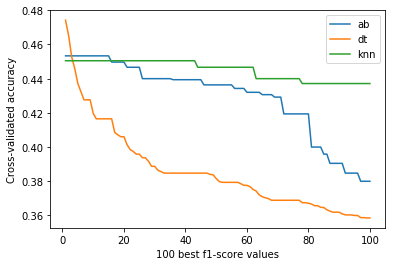

In [60]:
# Take scores from gridsearch for each model
# AdaBoost
grids_ab_scores = sorted([result for result in grids_ab.cv_results_['mean_test_score']], reverse=True)

# DecisionTree
grids_dt_scores = sorted([result for result in grids_dt.cv_results_['mean_test_score']], reverse=True)

# KNN
grids_knn_scores = sorted([result for result in grids_knn.cv_results_['mean_test_score']], reverse=True)

# Plot scores vs parameter
# https://stackoverflow.com/questions/4805048/how-to-get-different-colored-lines-for-different-plots-in-a-single-figure
plt.plot(list(range(1,101)), grids_ab_scores[:100])
plt.plot(list(range(1,101)), grids_dt_scores[:100])
plt.plot(list(range(1,101)), grids_knn_scores[:100])
plt.xlabel('100 best f1-score values')
plt.ylabel('Cross-validated accuracy')
plt.legend(['ab', 'dt', 'knn'])
plt.show()